In [1]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [2]:
!unzip /content/gdrive/MyDrive/Lung_cancer_project/train_224.zip -d .
!unzip /content/gdrive/MyDrive/Lung_cancer_project/test_224.zip -d .

Archive:  /content/gdrive/MyDrive/Lung_cancer_project/train_224.zip
   creating: ./train_224/
   creating: ./train_224/Aortic enlargement/
  inflating: ./train_224/Aortic enlargement/00675cd546313f912cadd4ad54415d69.png  
  inflating: ./train_224/Aortic enlargement/02fe3eea41166a1d3eb75307a12c4a63 - Copy.png  
  inflating: ./train_224/Aortic enlargement/02fe3eea41166a1d3eb75307a12c4a63.png  
  inflating: ./train_224/Aortic enlargement/05d45c0a96b2c363f8b9a34a1f181c58 - Copy.png  
  inflating: ./train_224/Aortic enlargement/05d45c0a96b2c363f8b9a34a1f181c58.png  
  inflating: ./train_224/Aortic enlargement/0b7995c5e532803dc1bd077eaa4d2a01.png  
  inflating: ./train_224/Aortic enlargement/0bdf902cc4ac4ad2c49059960f572ab2.png  
  inflating: ./train_224/Aortic enlargement/0bef06d948ac1fe20ade505ba9960885.png  
  inflating: ./train_224/Aortic enlargement/0cb91b8fe14a6d51725371b1956750a0.png  
  inflating: ./train_224/Aortic enlargement/0f1eba57237922d0f9ec0dee62793435.png  
  inflating: ./tr

In [3]:
!pip install pydicom
!pip install -q pypng
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 59.3 MB/s eta 0:00:00


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import pandas as pd
import pydicom
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
import png
import tensorflow_io as tfio
import matplotlib.image as mpimg
from PIL import Image
import random
import cv2
from google.colab.patches import cv2_imshow
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import pickle

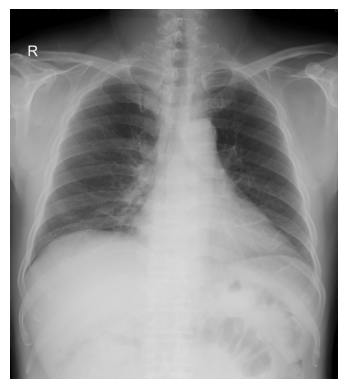

In [5]:

# Path to the DICOM file
image_path = '/content/gdrive/MyDrive/Lung_cancer_project/00a2145de1886cb9eb88869c85d74080.dicom'

# Read the DICOM file as bytes
image_bytes = tf.io.read_file(image_path)

# Decode the DICOM image
image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

# Remove extra dimensions
image = tf.squeeze(image, axis=0)

# Display the image using Matplotlib
plt.imshow(image.numpy(), cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


# Image format conversion

In [6]:
# convert dcm file into png format
image_path = "/content/gdrive/MyDrive/Lung_cancer_project/00a2145de1886cb9eb88869c85d74080.dicom"
img = pydicom.dcmread(image_path)
path = image_path.split("/")[-1].split(".")[0]
shape = img.pixel_array.shape
# Convert to float to avoid overflow or underflow losses.
image_2d = img.pixel_array.astype(float)

# Rescaling grey scale between 0-255
image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
# Convert to uint
image_2d_scaled = np.uint8(image_2d_scaled)
# Write the PNG file
with  open('{}.png'.format(path),'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)
print("Converted dcm file into png format:",'{}.png'.format(path))



/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Converted dcm file into png format: 00a2145de1886cb9eb88869c85d74080.png


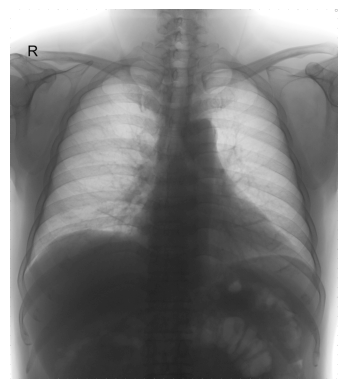

In [7]:
# visualize converted image path
png_path = '{}.png'.format(path)

# Read the PNG file and display it
img = mpimg.imread(png_path)

# Display the PNG image
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

# Visulize Train Dataset

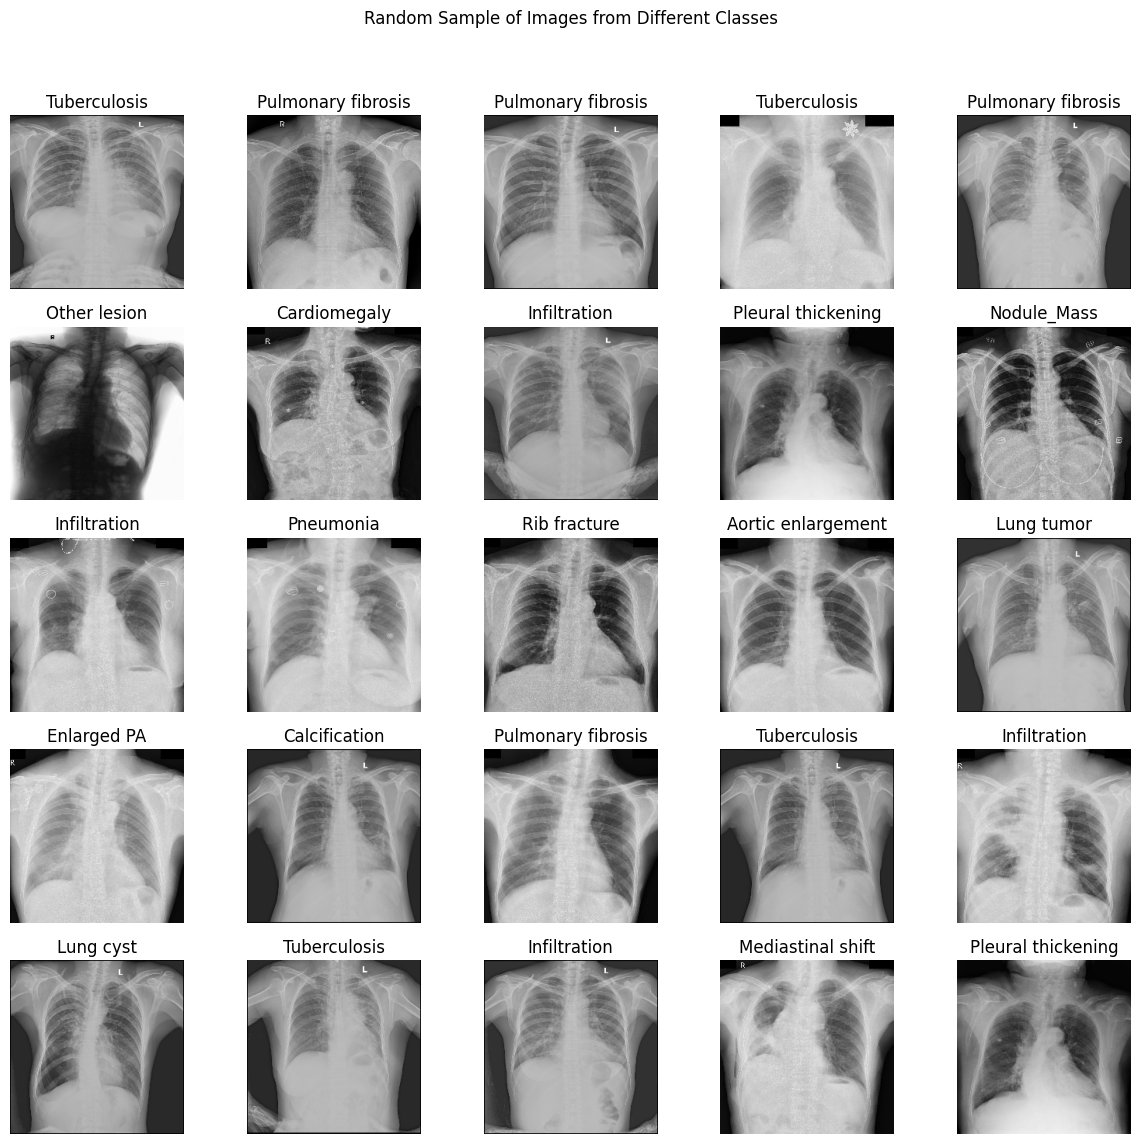

In [8]:
# Get all image paths from the folder
imagePaths = list(paths.list_images("/content/train_224"))

# Function to display a grid of images
def display_images(image_paths, title, cols=5, num_images=25):  # Set cols and add num_images
    random.shuffle(image_paths)  # Shuffle the image paths randomly
    num_images = min(len(image_paths), num_images)  # Limit the number of images to display
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(12, 12))  # Adjust figure size to accommodate more rows
    plt.suptitle(title)

    for i, image_path in enumerate(image_paths[:num_images]):
        plt.subplot(rows, cols, i + 1)
        img = Image.open(image_path)
        img = img.convert('RGB')
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(image_path)))
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display a random set of images in a 5x5 grid
display_images(imagePaths, title="Random Sample of Images from Different Classes", num_images=25)


# Visulize Test Dataset

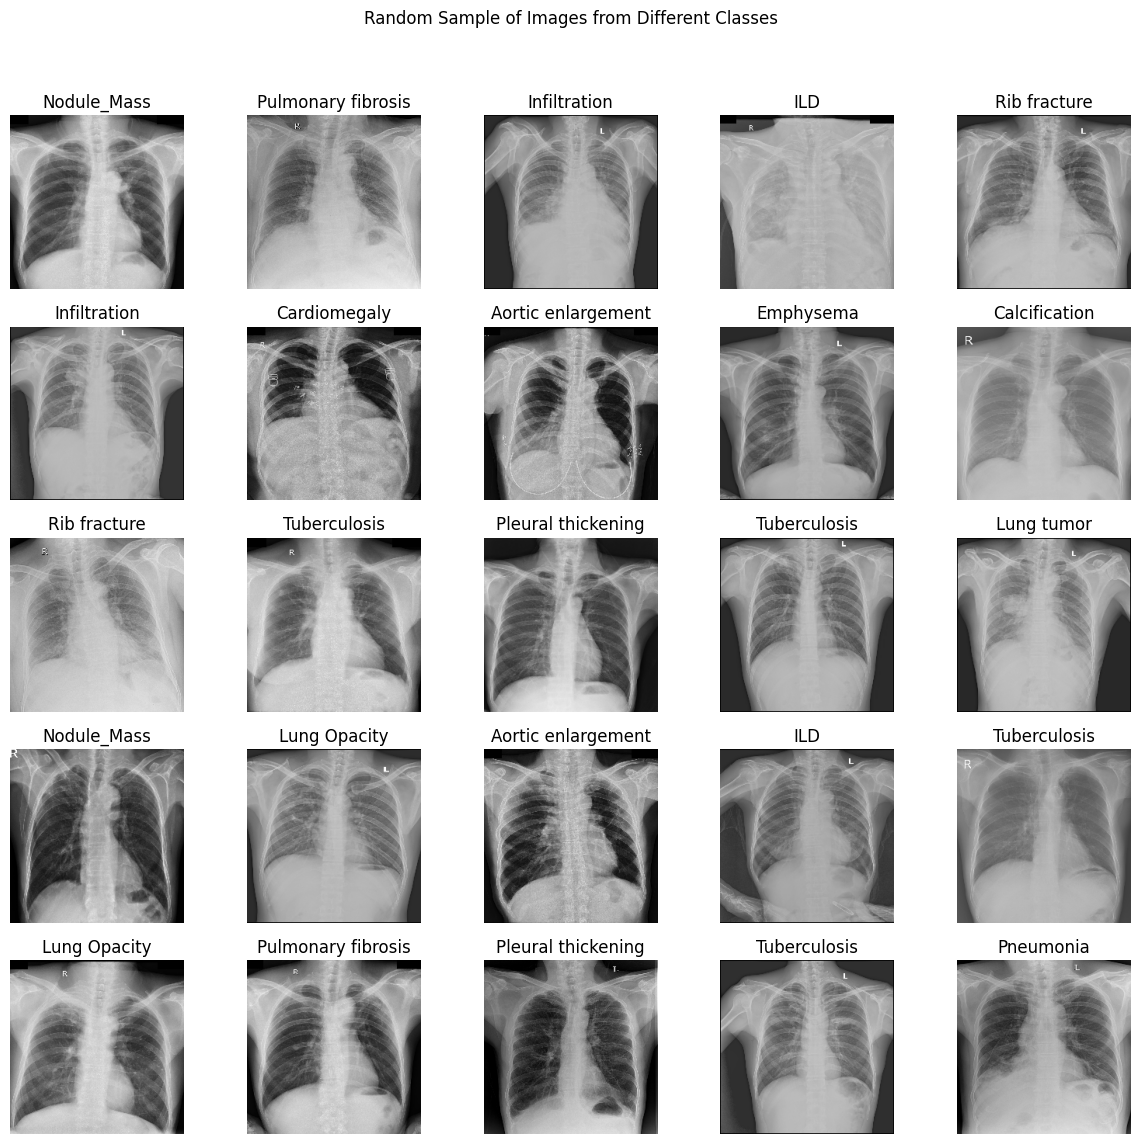

In [9]:
# Get all image paths from the folder
imagePaths = list(paths.list_images("/content/test__224"))

# Function to display a grid of images
def display_images(image_paths, title, cols=5, num_images=25):  # Set cols and add num_images
    random.shuffle(image_paths)  # Shuffle the image paths randomly
    num_images = min(len(image_paths), num_images)  # Limit the number of images to display
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(12, 12))  # Adjust figure size to accommodate more rows
    plt.suptitle(title)

    for i, image_path in enumerate(image_paths[:num_images]):
        plt.subplot(rows, cols, i + 1)
        img = Image.open(image_path)
        img = img.convert('RGB')
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(image_path)))
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display a random set of images in a 5x5 grid
display_images(imagePaths, title="Random Sample of Images from Different Classes", num_images=25)


# Data Augmentation

In [10]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
# Initialize the image data generator with limited augmentation parameters
aug = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True
)

# Data Augmentation for Train Dataset

In [11]:
import os
from tqdm.notebook import tqdm
if not os.path.exists("/content/train_img"):
    os.mkdir("/content/train_img")
path = "/content/train_224/"
filePaths = os.listdir(path)
for filepath in tqdm(filePaths):
    print(filepath)
    imagePaths = os.listdir(path+filepath)
    if 100>len(imagePaths):
        for image in imagePaths[:len(imagePaths)]:
            # load the input image, convert it to a NumPy array, and then
            # reshape it to have an extra dimension
            print("[INFO] loading example image...")
            image = load_img(path+filepath+"/"+image)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            total = 0
            total_count = int(100/len(imagePaths))
            if total_count == 1:
                total_count = 2
            print(total_count)
            # construct the actual Python generator
            if not os.path.exists(f'/content/train_img/{filepath}/'):
                os.mkdir(f'/content/train_img/{filepath}/')
            print("[INFO] generating images...")
            imageGen = aug.flow(image, batch_size=1, save_to_dir=f'/content/train_img/{filepath}/',
                                save_prefix="image", save_format="png")

            # loop over examples from our image data augmentation generator
            for image in imageGen:
                # increment our counter
                total += 1
                if total == total_count:
                    break
    else:
        # move foldedestination folder
        source_folder = f"/content/train_224/{filepath}"
        destination_folder = f'/content/train_img'
        source_path = os.path.join(source_folder)
        destination_path = os.path.join(destination_folder)
        shutil.move(source_path, destination_path)



  0%|          | 0/26 [00:00<?, ?it/s]

Lung cyst
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images...
[INFO] loading example image...
4
[INFO] generating images..

# Data Augmentation for Test Dataset

In [12]:
import os
from tqdm.notebook import tqdm
if not os.path.exists("/content/test_img"):
    os.mkdir("/content/test_img")
path = "/content/test__224/"
filePaths = os.listdir(path)
for filepath in tqdm(filePaths):
    print(filepath)
    imagePaths = os.listdir(path+filepath)
    if 50>len(imagePaths):
        for image in imagePaths[:len(imagePaths)]:
            # load the input image, convert it to a NumPy array, and then
            print("[INFO] loading example image...")
            image = load_img(path+filepath+"/"+image)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            total = 0
            total_count = int(50/len(imagePaths))
            if total_count == 1:
                total_count = 2
            print(total_count)
            # construct the actual Python generator
            if not os.path.exists(f'/content/test_img/{filepath}/'):
                os.mkdir(f'/content/test_img/{filepath}/')
            print("[INFO] generating images...")
            imageGen = aug.flow(image, batch_size=1, save_to_dir=f'/content/test_img/{filepath}/',
                                save_prefix="image", save_format="png")

            # loop over examples from our image data augmentation generator
            for image in imageGen:
                # increment our counter
                total += 1
                if total == total_count:
                    break
    else:
        # move foldedestination folder
        source_folder = f"/content/test__224/{filepath}"
        destination_folder = f'/content/test_img/'
        source_path = os.path.join(source_folder)
        destination_path = os.path.join(destination_folder)
        shutil.move(source_path, destination_path)



  0%|          | 0/26 [00:00<?, ?it/s]

Lung cyst
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
[INFO] loading example image...
5
[INFO] generating images...
Aortic enlargement
Calcification
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example image...
2
[INFO] generating images...
[INFO] loading example imag

# Dataset Preprocessing(Image Resizing)

In [13]:
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			if image is None or image.size == 0:
				print(f"Error loading image: {imagePath}")
				continue  # Skip this image
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

In [14]:
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [15]:
class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

In [16]:
# # initialize the image preprocessors
sp = SimplePreprocessor(224,224)
iap = ImageToArrayPreprocessor()

In [17]:
# get all images path from train folder
train_img = list(paths.list_images('/content/train_img'))
train_classNames = [pt.split(os.path.sep)[-2] for pt in train_img]
train_classNames = [str(x) for x in np.unique(train_classNames)]
train_classNames

['Aortic enlargement',
 'Atelectasis',
 'COPD',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Lung tumor',
 'Mediastinal shift',
 'Nodule_Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumonia',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'Tuberculosis']

In [18]:
# load  train_imagePaths

def load_train():
    sdl = SimpleDatasetLoader(preprocessors=[iap])
    train_data = None
    train_labels = None

    try:
        (train_data, train_labels) = sdl.load(train_img, verbose=500)
        train_data = train_data.astype('float32') / 255
    except Exception as e:
        print(f"An error occurred while loading the train dataset: {str(e)}")

    return train_data, train_labels

train_data, train_labels = load_train()
np.save("/content/gdrive/MyDrive/Lung_cancer_project/train_data.npy",train_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/train_lables.npy",train_labels)

[INFO] processed 500/3426
[INFO] processed 1000/3426
[INFO] processed 1500/3426
[INFO] processed 2000/3426
[INFO] processed 2500/3426
[INFO] processed 3000/3426


In [19]:
# get all images path from test folder
test_img = list(paths.list_images('/content/test_img'))
test_classNames = [pt.split(os.path.sep)[-2] for pt in test_img]
test_classNames = [str(x) for x in np.unique(test_classNames)]
test_classNames

['Aortic enlargement',
 'Atelectasis',
 'COPD',
 'Calcification',
 'Cardiomegaly',
 'Clavicle fracture',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Enlarged PA',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Lung cavity',
 'Lung cyst',
 'Lung tumor',
 'Mediastinal shift',
 'Nodule_Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumonia',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'Rib fracture',
 'Tuberculosis']

In [20]:
# load  test_imagePaths

def load_test():
    sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
    test_data = None
    test_labels = None

    try:
        (test_data, test_labels) = sdl.load(test_img, verbose=500)
        test_data = test_data.astype('float32') / 255
    except Exception as e:
        print(f"An error occurred while loading the train dataset: {str(e)}")

    return test_data, test_labels

test_data, test_labels = load_test()
np.save("/content/gdrive/MyDrive/Lung_cancer_project/test_data.npy",test_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/test_lables.npy",test_labels)

[INFO] processed 500/2108
[INFO] processed 1000/2108
[INFO] processed 1500/2108
[INFO] processed 2000/2108


In [21]:
train_data = np.load("/content/gdrive/MyDrive/Lung_cancer_project/train_data.npy")
test_data = np.load("/content/gdrive/MyDrive/Lung_cancer_project/test_data.npy")


In [93]:
train_labels = np.load("/content/gdrive/MyDrive/Lung_cancer_project/train_lables.npy")
test_labels = np.load("/content/gdrive/MyDrive/Lung_cancer_project/test_lables.npy")

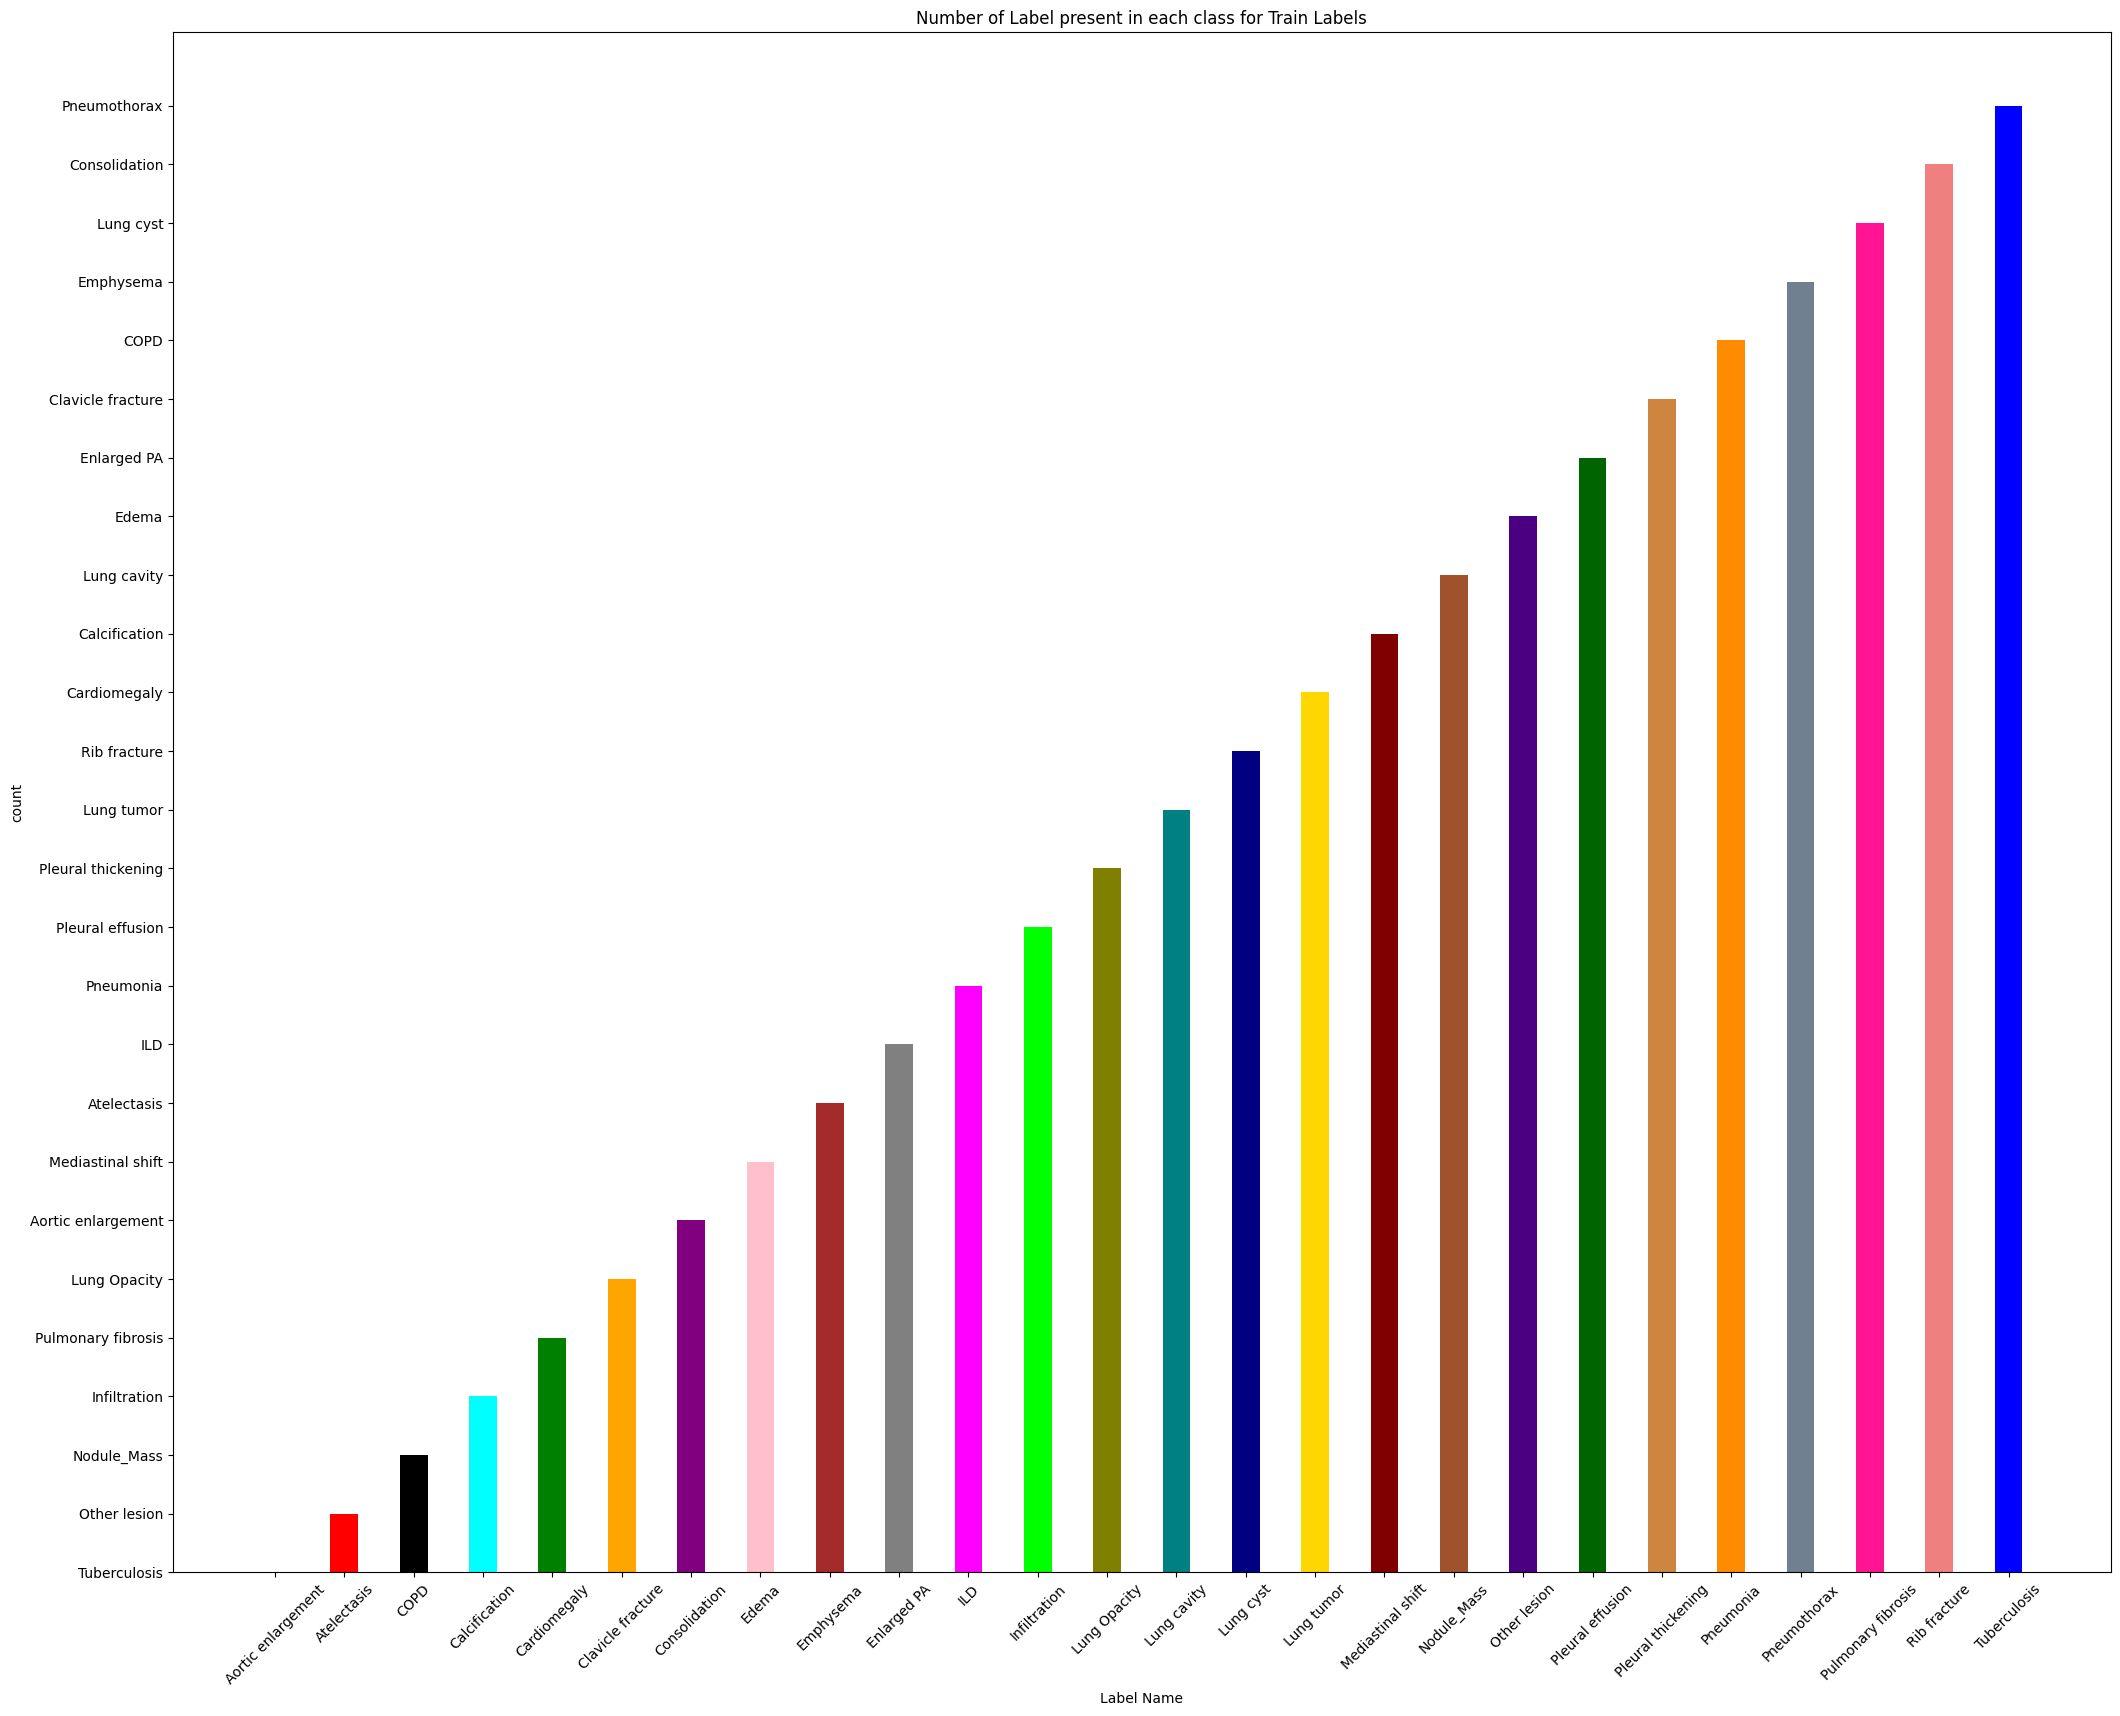

In [100]:
# Original dataset classes count
train_label_df = pd.DataFrame(train_labels,columns = ["Class"])
class_data = train_label_df["Class"].value_counts()
# creating the dataset
label_data = class_data.index

fig = plt.figure(figsize = (25,20))

label_name = np.unique(train_labels)
# creating the bar plot
plt.bar(label_name,label_data ,color = ["blue", "red", "black", "cyan", "green", "orange", "purple", "pink", "brown", "gray", "magenta", "lime", "olive", "teal", "navy", "gold", "maroon", "sienna", "indigo", "darkgreen", "peru", "darkorange", "slategray", "deeppink", "lightcoral"],
        width = 0.4)
plt.xticks(rotation=45)
plt.xlabel("Label Name")
plt.ylabel("count")
plt.title("Number of Label present in each class for Train Labels")
plt
plt.show()

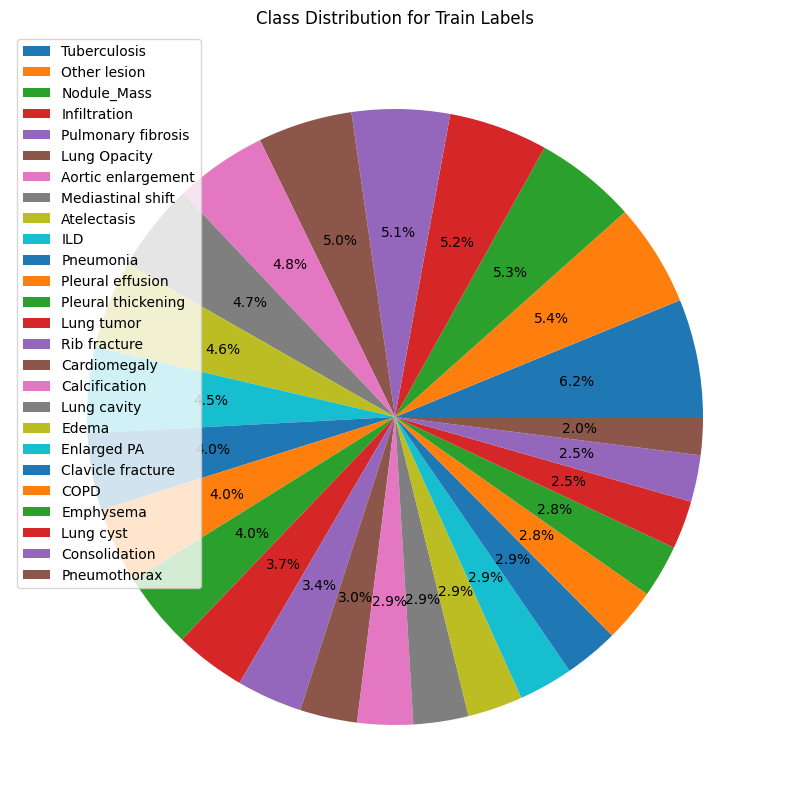

In [95]:
# Plot a pie chart for the class distribution after Random Over-Sampling
plt.figure(figsize=(15,10))
train_label_df["Class"].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=None)
plt.title('Class Distribution for Train Labels')
plt.legend(labels=train_label_df["Class"].value_counts().index, loc='best')
plt.ylabel('')
plt.show()

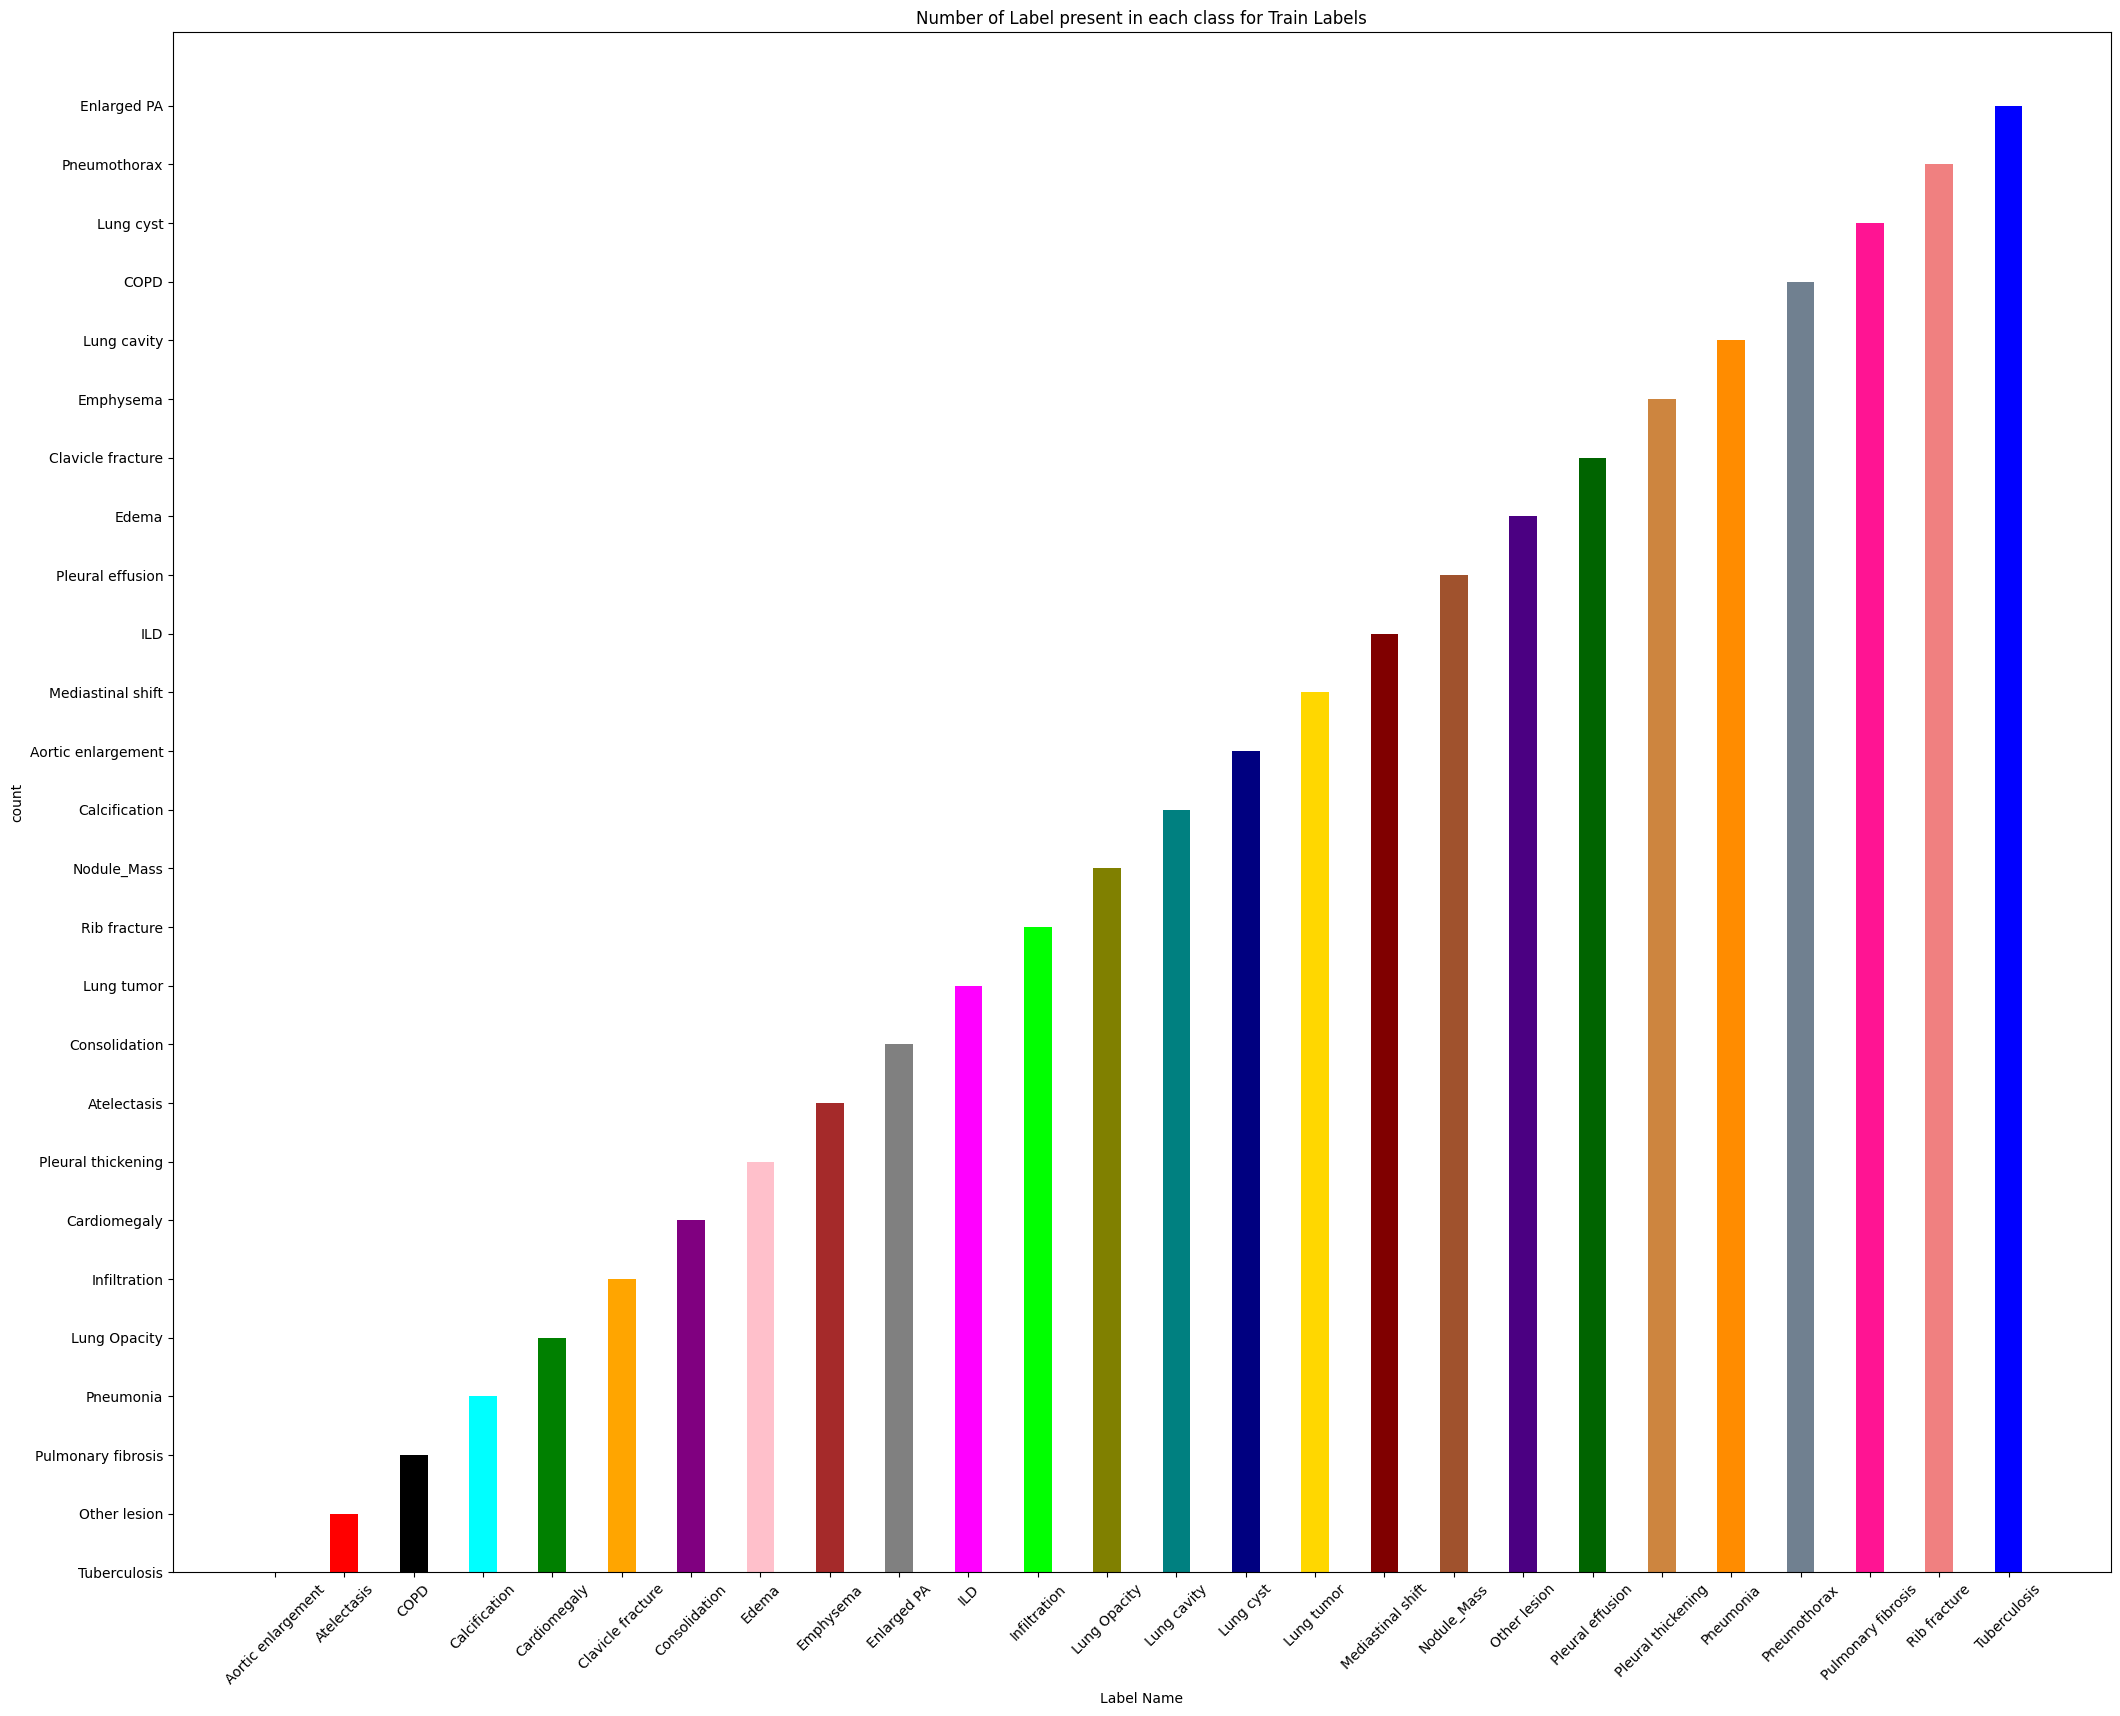

In [99]:
# Original dataset classes count
test_label_df = pd.DataFrame(test_labels,columns = ["Class"])
class_data = test_label_df["Class"].value_counts()
# creating the dataset
label_data = class_data.index

fig = plt.figure(figsize = (25,20))

label_name = np.unique(test_labels)
# creating the bar plot
plt.bar(label_name,label_data ,color = ["blue", "red", "black", "cyan", "green", "orange", "purple", "pink", "brown", "gray", "magenta", "lime", "olive", "teal", "navy", "gold", "maroon", "sienna", "indigo", "darkgreen", "peru", "darkorange", "slategray", "deeppink", "lightcoral"],
        width = 0.4)
plt.xticks(rotation=45)
plt.xlabel("Label Name")
plt.ylabel("count")
plt.title("Number of Label present in each class for Train Labels")
plt
plt.show()

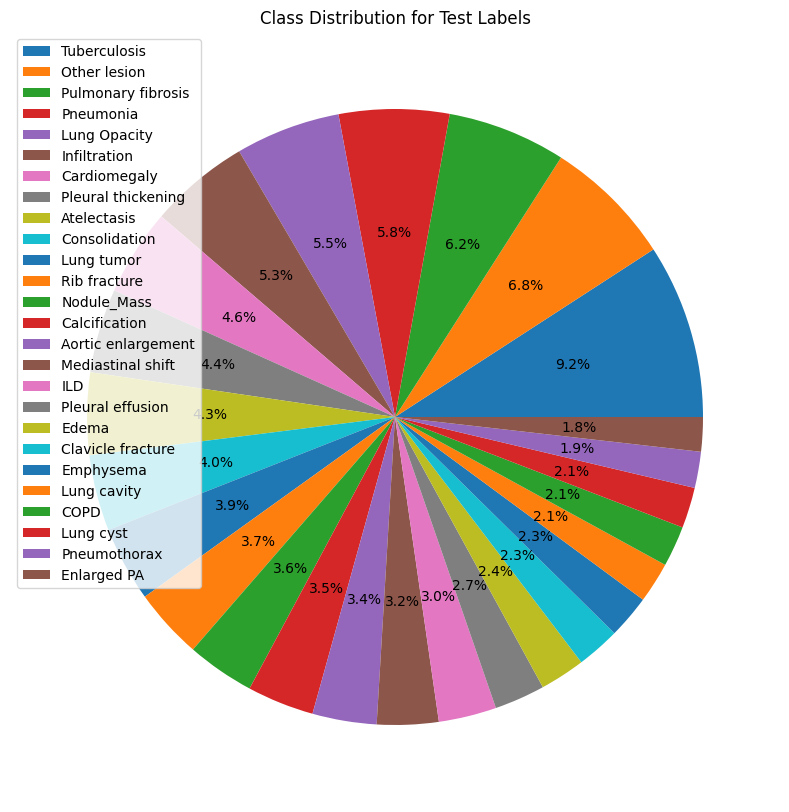

In [97]:
# Plot a pie chart for the class distribution after Random Over-Sampling
plt.figure(figsize=(15,10))
test_label_df["Class"].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=None)
plt.title('Class Distribution for Test Labels')
plt.legend(labels=test_label_df["Class"].value_counts().index, loc='best')
plt.ylabel('')
plt.show()

# Feature Extraction

In [22]:
#function to extract features from the dataset by a given pretrained model
img_size = (224,224, 3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)

    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps


In [23]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features_train = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size,train_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/inception_features_train.npy",inception_features_train)

108/108 [==============================] - 17s 69ms/step
Feature maps shape:  (3426, 2048)


In [24]:
# Extract features using InceptionV3
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features_test = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size,test_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/inception_features_test.npy",inception_features_test)

66/66 [==============================] - 7s 90ms/step
Feature maps shape:  (2108, 2048)


In [25]:
# Extract features using Xception
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features_train = get_features(Xception,
                                 xception_preprocessor,
                                 img_size,train_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/xception_features_train.npy",xception_features_train)

108/108 [==============================] - 18s 143ms/step
Feature maps shape:  (3426, 2048)


In [26]:
# Extract features using Xception
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features_test = get_features(Xception,
                                 xception_preprocessor,
                                 img_size,test_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/xception_features_test.npy",xception_features_test)

66/66 [==============================] - 11s 160ms/step
Feature maps shape:  (2108, 2048)


In [27]:
# Extract features using InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features_train = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size,train_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/inc_resnet_features_train.npy",inc_resnet_features_train)

108/108 [==============================] - 22s 161ms/step
Feature maps shape:  (3426, 1536)


In [28]:
# Extract features using InceptionResNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features_test = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size,test_data)
np.save("/content/gdrive/MyDrive/Lung_cancer_project/inc_resnet_features_test.npy",inc_resnet_features_test)

66/66 [==============================] - 15s 176ms/step
Feature maps shape:  (2108, 1536)


In [29]:
# Extract features using NASNetLarge
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features_train = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, train_data)

np.save("/content/gdrive/MyDrive/Lung_cancer_project/nasnet_features_train_features_train.npy",nasnet_features_train)

108/108 [==============================] - 47s 377ms/step
Feature maps shape:  (3426, 4032)


In [30]:
# Extract features using NASNetLarge
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features_test = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, test_data)

np.save("/content/gdrive/MyDrive/Lung_cancer_project/nasnet_features_train_features_test.npy",nasnet_features_test)

66/66 [==============================] - 30s 384ms/step
Feature maps shape:  (2108, 4032)


In [31]:
# load inception train and test
inception_features_train = np.load("/content/gdrive/MyDrive/Lung_cancer_project/inception_features_train.npy")
inception_features_test = np.load("/content/gdrive/MyDrive/Lung_cancer_project/inception_features_test.npy")
print("inception features train shape",inception_features_train.shape,"inception features test shape",inception_features_test.shape)

# load xception train and test
xception_features_train = np.load("/content/gdrive/MyDrive/Lung_cancer_project/xception_features_train.npy")
xception_features_test = np.load("/content/gdrive/MyDrive/Lung_cancer_project/xception_features_test.npy")
print("xception features train shape",xception_features_train.shape,"xception features test shape",xception_features_test.shape)

# load xception train and test
inc_resnet_features_train = np.load("/content/gdrive/MyDrive/Lung_cancer_project/inc_resnet_features_train.npy")
inc_resnet_features_test = np.load("/content/gdrive/MyDrive/Lung_cancer_project/inc_resnet_features_test.npy")
print("inc resnet features train shape",inc_resnet_features_train.shape,"inc resnet features test shape",inc_resnet_features_test.shape)

nasnet_features_train = np.load("/content/gdrive/MyDrive/Lung_cancer_project/nasnet_features_train_features_train.npy")
nasnet_features_test = np.load("/content/gdrive/MyDrive/Lung_cancer_project/nasnet_features_train_features_test.npy")
print("nasnet features train shape",nasnet_features_train.shape,"nasnet features  test shape",nasnet_features_test.shape)

inception features train shape (3426, 2048) inception features test shape (2108, 2048)
xception features train shape (3426, 2048) xception features test shape (2108, 2048)
inc resnet features train shape (3426, 1536) inc resnet features test shape (2108, 1536)
nasnet features train shape (3426, 4032) nasnet features  test shape (2108, 4032)


In [88]:
#Creating final featuremap by combining all extracted features
final_features_train = np.concatenate([inception_features_train,
                                 xception_features_train,
                                 inc_resnet_features_train,
                                 nasnet_features_train,], axis=-1) #axis=-1 to concatinate horizontally
print('Final feature maps train shape', final_features_train.shape)

Final feature maps train shape (3426, 9664)


In [89]:
#Creating final featuremap by combining all extracted features

final_features_test = np.concatenate([inception_features_test,
                                 xception_features_test,
                                 inc_resnet_features_test,
                                 nasnet_features_test,], axis=-1) #axis=-1 to concatinate horizontally
print('Final feature maps test shape', final_features_test.shape)

Final feature maps test shape (2108, 9664)


In [142]:
print('final_features_train',final_features_train.shape,'final_features_test',final_features_test.shape,'train_labels',train_labels.shape,'test_labels',test_labels.shape)

final_features_train (3426, 9664) final_features_test (2108, 9664) train_labels (3426,) test_labels (2108,)


In [144]:
train_val_data = {'total data':[len(final_features_train),len(final_features_test),len(train_labels),len(test_labels)]}
pd.DataFrame.from_dict(train_val_data, orient='index',columns=["final_features_train","final_features_test","train_labels ","test_labels "])

,final_features_train,final_features_test,train_labels,test_labels
total data,3426,2108,3426,2108


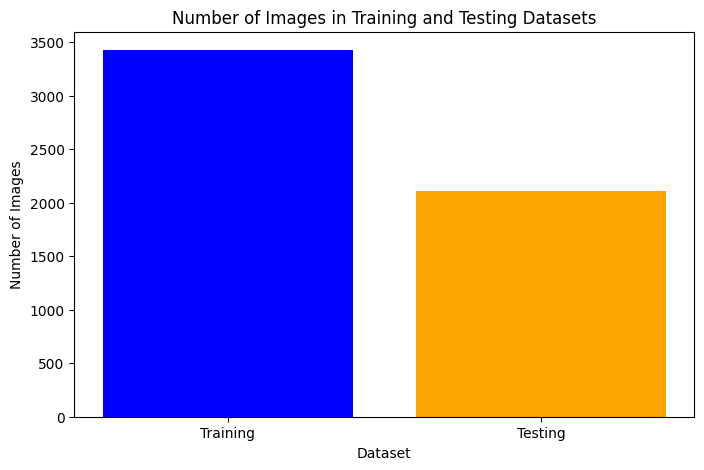

In [145]:
# Calculate the number of images for training and testing
num_train_images = len(final_features_train)
num_test_images = len(final_features_test)

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Training', 'Testing'], [num_train_images, num_test_images], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Training and Testing Datasets')
plt.show()


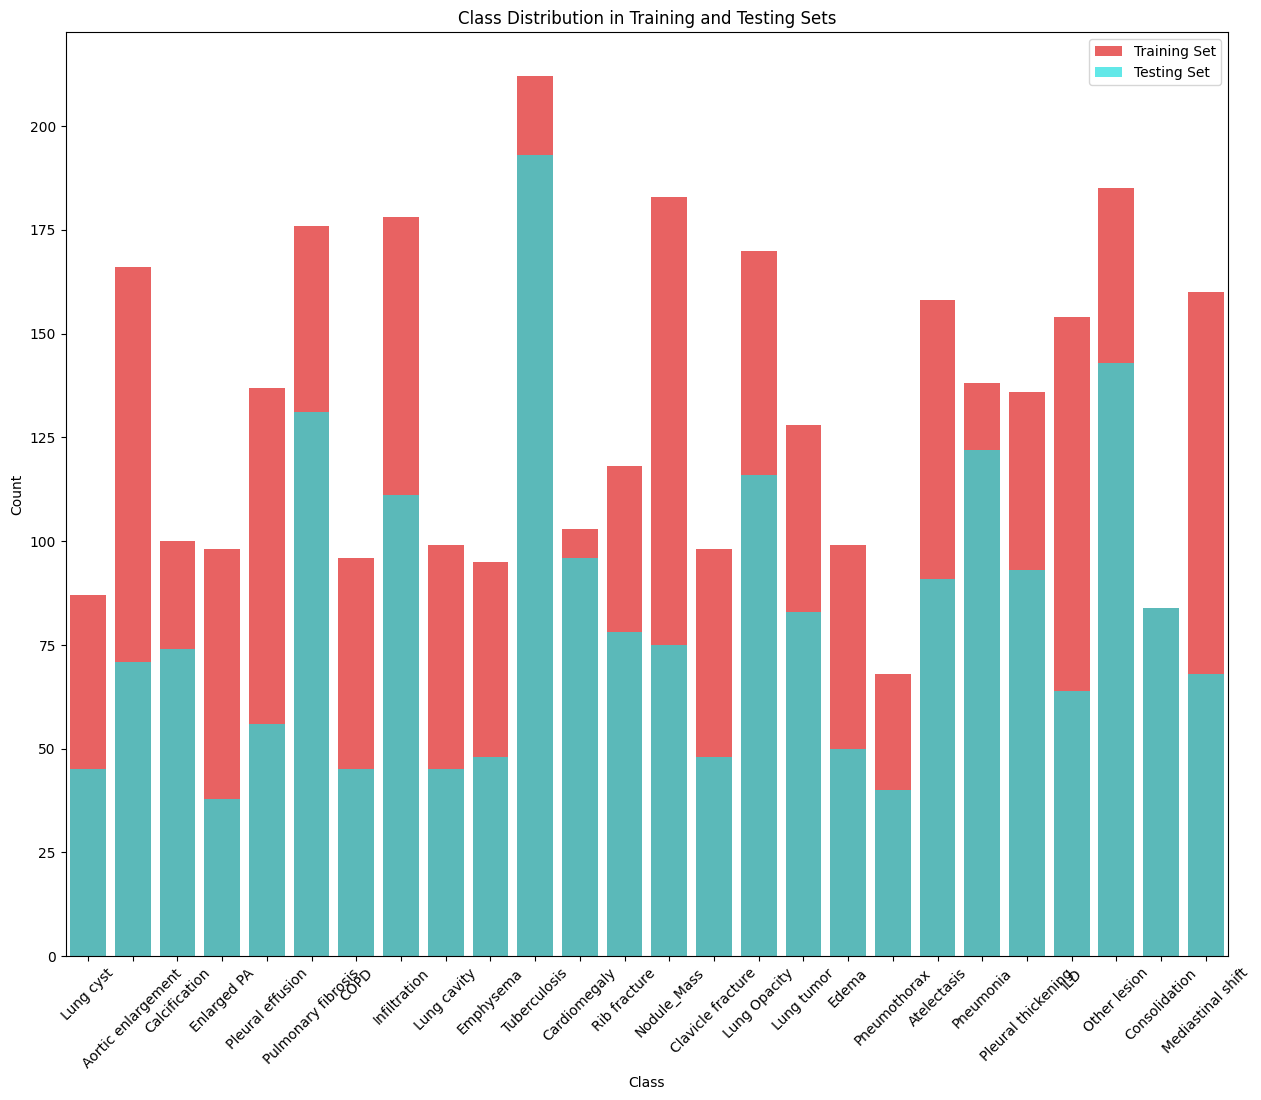

In [148]:
# Convert y_train and y_test back to DataFrames
train_data = pd.DataFrame({'Class': train_labels})
test_data = pd.DataFrame({'Class': test_labels})

train_color = ["red","red","red","red","red"]
test_color = ["cyan","cyan","cyan","cyan","cyan"]

# Create a bar plot to visualize the class distribution in the training and testing sets
plt.figure(figsize=(15, 12))
sns.countplot(x='Class', data=train_data, palette=train_color, alpha=0.7, label='Training Set')
sns.countplot(x='Class', data=test_data, palette=test_color, alpha=0.7, label='Testing Set')
plt.title('Class Distribution in Training and Testing Sets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend()
plt.show()


# Training using RandomForestClassifier Algorithm

In [111]:
import numpy as np
import pickle
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Create a Decision Tree classifier
clf = RandomForestClassifier()

# Train the classifier on the training data
clf.fit(final_features_train,train_labels)

Accuracy of Random Forest Classifier: 0.5759013282732448


# Validaiton & Evaluation

In [112]:
rf_weight = pickle.load(open("/content/gdrive/MyDrive/Lung_cancer_project/rf_Weight.p","rb"))
# Make predictions on the test data
y_pred = rf_weight.predict(final_features_test)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of Random Forest Classifier:", accuracy)

Accuracy of Random Forest Classifier: 0.5759013282732448


# Classification Report

In [129]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,y_pred))

                    precision    recall  f1-score   support

Aortic enlargement       0.40      0.72      0.51        71
       Atelectasis       0.79      0.69      0.74        91
              COPD       0.42      0.44      0.43        45
     Calcification       0.68      0.41      0.51        74
      Cardiomegaly       0.75      0.49      0.59        96
 Clavicle fracture       0.89      0.88      0.88        48
     Consolidation       0.68      0.36      0.47        84
             Edema       0.76      0.94      0.84        50
         Emphysema       0.62      0.52      0.57        48
       Enlarged PA       0.50      0.47      0.49        38
               ILD       0.09      0.12      0.11        64
      Infiltration       0.47      0.62      0.54       111
      Lung Opacity       0.65      0.66      0.65       116
       Lung cavity       0.77      0.67      0.71        45
         Lung cyst       0.70      0.47      0.56        45
        Lung tumor       0.69      0.77

# Confusion Matrix

Confusion Matrix:


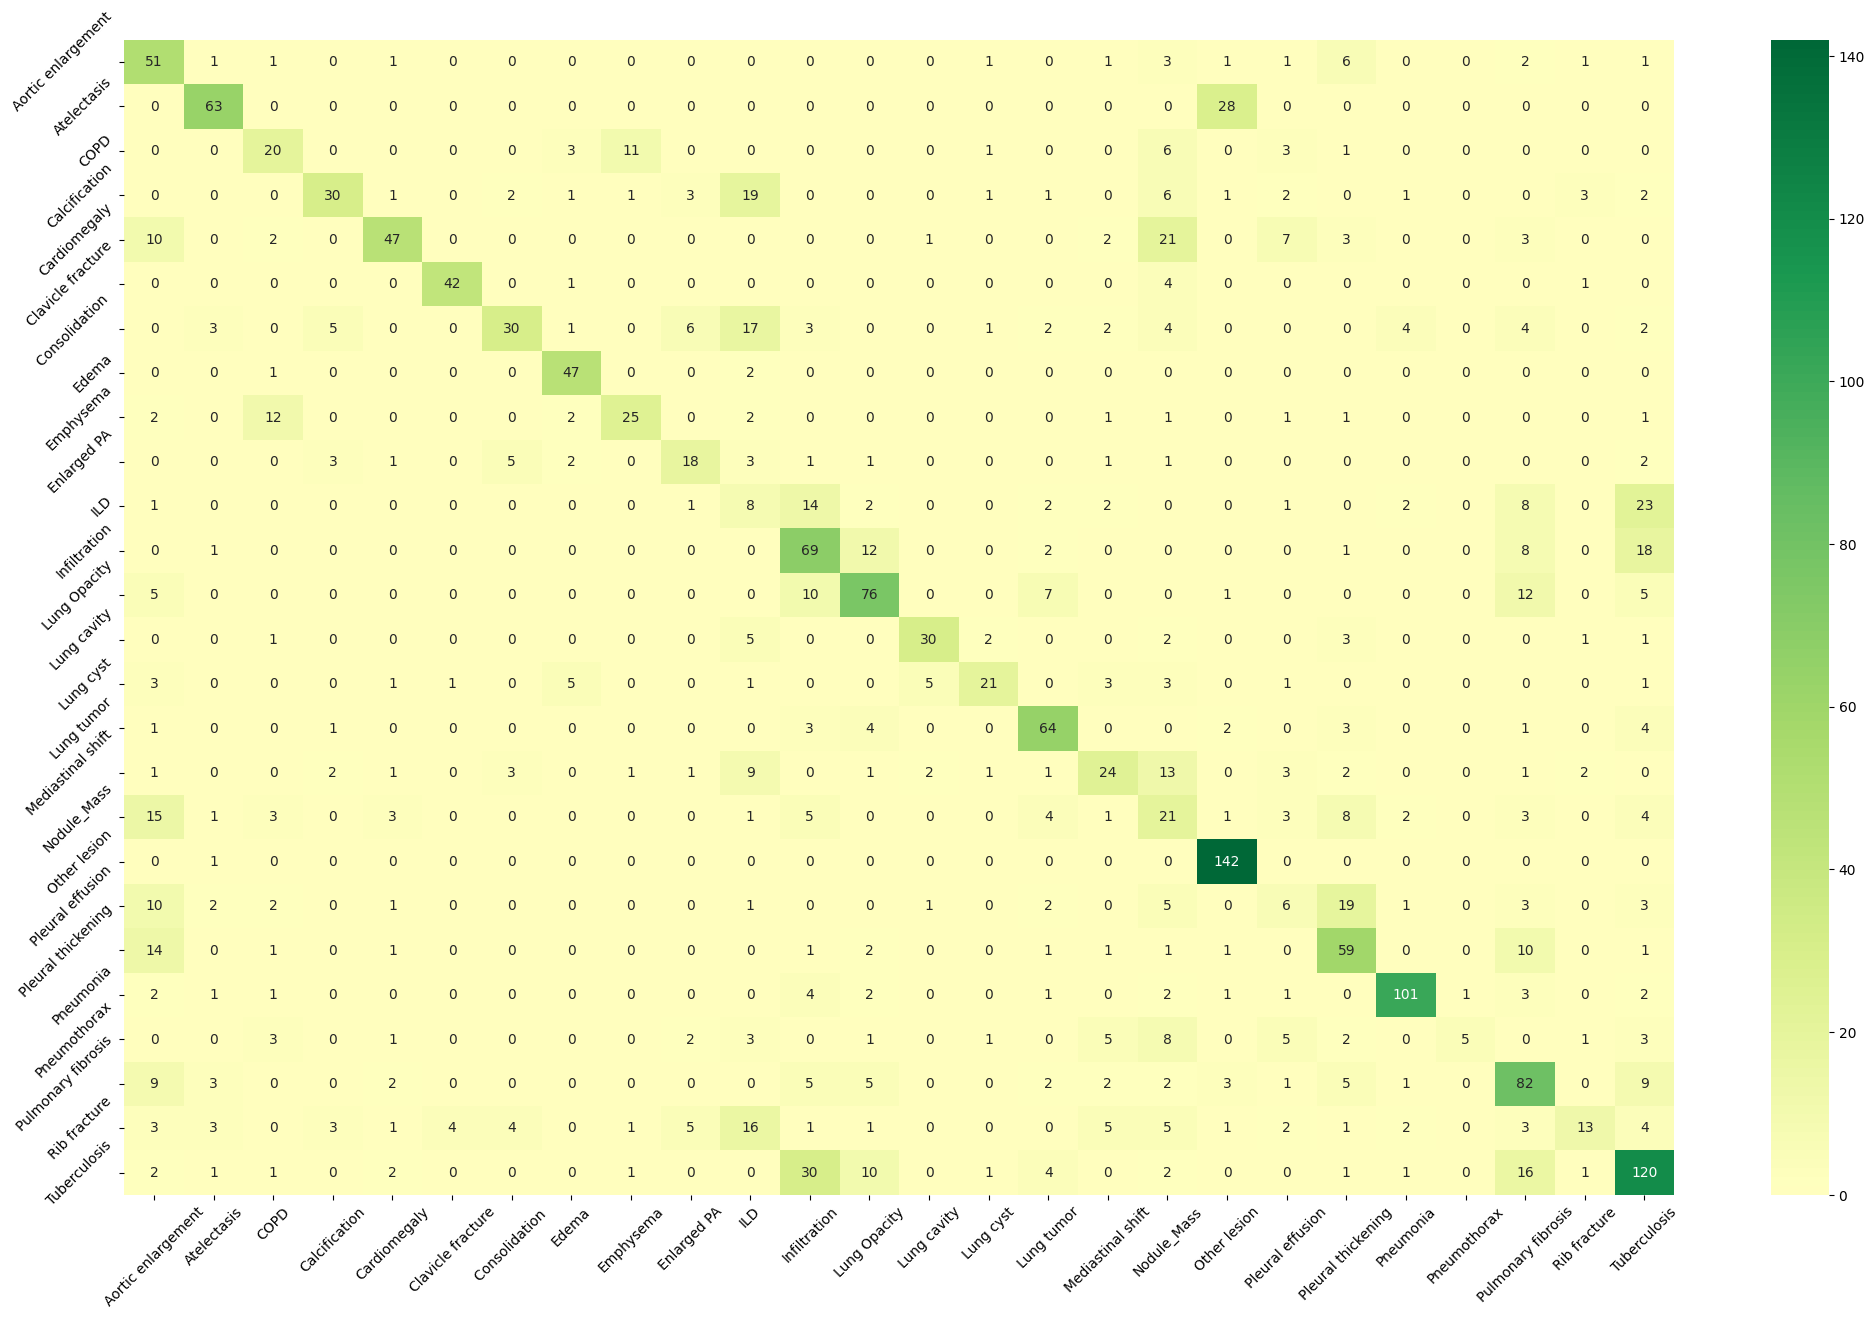

In [149]:
# Compute the error.
from sklearn.metrics import confusion_matrix
import seaborn as sns
CM = confusion_matrix(test_labels, y_pred)
print('Confusion Matrix:')
classes = ['Aortic enlargement','Atelectasis','COPD','Calcification','Cardiomegaly','Clavicle fracture','Consolidation ','Edema','Emphysema','Enlarged PA','ILD','Infiltration','Lung Opacity','Lung cavity','Lung cyst','Lung tumor','Mediastinal shift','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumonia','Pneumothorax','Pulmonary fibrosis','Rib fracture','Tuberculosis']
# drawing confusion matrix
plt.figure(figsize = (25,15))
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="RdYlGn",xticklabels = classes,yticklabels = classes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
print()